# *(Joglekar, et. al, 2018)*: Inter-areal Balanced Amplification taichi customized operators

Using taichi customized operators to implement the model in *(Joglekar, et. al, 2018)*.:

- Joglekar, Madhura R., et al. "Inter-areal balanced amplification enhances signal propagation in a large-scale circuit model of the primate cortex." Neuron 98.1 (2018): 222-234.

In [7]:
import brainpy as bp
import brainpy.math as bm
from brainpy import neurons
from brainpy._src.math.interoperability import as_jax
from brainpy._src.math.ndarray import _get_dtype
from brainpy._src.math.op_register import XLACustomOp
from brainpy._src.math.tifunc import (lfsr88_key, lfsr88_uniform, lfsr88_normal, lfsr88_random_integers)

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import taichi as ti
from jax import vmap
from scipy.io import loadmat
from typing import Tuple, Optional
from functools import partial

In [8]:
# This model should be run on a GPU device

bm.set_platform('gpu')

In [9]:
bp.__version__

'2.5.0'

In [10]:
# Define customized operators

def _reverse(shape):
    return shape[::-1]

def multiple_area_customized_op_E(
        events: jax.Array,
        weight: float,
        conn_prob: float,
        seed: Optional[int] = None,
        *,
        shape: Tuple[int, int],
        area_num: int,
        transpose: bool = False,
        outdim_parallel: bool = False,
):
    events = as_jax(events)
    if isinstance(weight, float): weight = as_jax(weight)
    weight = jnp.atleast_1d(as_jax(weight))
    conn_len = jnp.ceil(1 / conn_prob) * 2 - 1
    conn_len = jnp.asarray(jnp.atleast_1d(conn_len), dtype=jnp.int32)
    if seed is None:
        with jax.ensure_compile_time_eval():
            seed = np.random.randint(0, int(1e8), 1)
    seed = jnp.atleast_1d(jnp.asarray(seed, dtype=jnp.uint32))
    return raw_multiple_area_customized_op_E(events, weight, conn_len, seed, shape=shape, area_num=area_num,
                                            transpose=transpose, outdim_parallel=outdim_parallel)[0]
    

def multiple_area_customized_op_I(
        events: jax.Array,
        weight: float,
        conn_prob: float,
        seed: Optional[int] = None,
        *,
        shape: Tuple[int, int],
        area_num: int,
        transpose: bool = False,
        outdim_parallel: bool = False,
):
    events = as_jax(events)
    if isinstance(weight, float): weight = as_jax(weight)
    weight = jnp.atleast_1d(as_jax(weight))
    conn_len = jnp.ceil(1 / conn_prob) * 2 - 1
    conn_len = jnp.asarray(jnp.atleast_1d(conn_len), dtype=jnp.int32)
    if seed is None:
        with jax.ensure_compile_time_eval():
            seed = np.random.randint(0, int(1e8), 1)
    seed = jnp.atleast_1d(jnp.asarray(seed, dtype=jnp.uint32))
    return raw_multiple_area_customized_op_I(events, weight, conn_len, seed, shape=shape, area_num=area_num,
                                            transpose=transpose, outdim_parallel=outdim_parallel)[0]

@ti.kernel
def _multiple_area_event_mv_prob_homo_bool_irregular_cpu_E(
        events: ti.types.ndarray(ndim=1),
        weight: ti.types.ndarray(ndim=1),
        clen: ti.types.ndarray(ndim=1),
        seed: ti.types.ndarray(ndim=1),
        out: ti.types.ndarray(ndim=2)
):
    num_row = out.shape[1]
    num_col = events.shape[0]
    weight0 = weight[0]
    clen0 = clen[0]

    for i_col in range(num_col):
        if events[i_col]:
            for i_area in range(out.shape[0]):
                key = lfsr88_key(seed[i_area] + i_col)
                key, i_row = lfsr88_random_integers(key, 0, clen0 - 1)
                while i_row < num_row:
                    out[i_area, i_row] += weight0
                    key, inc = lfsr88_random_integers(key, 1, clen0)
                    i_row += inc


@ti.kernel
def _multiple_area_event_mv_prob_homo_bool_irregular_gpu_E(
        events: ti.types.ndarray(ndim=1),
        weight: ti.types.ndarray(ndim=1),
        clen: ti.types.ndarray(ndim=1),
        seed: ti.types.ndarray(ndim=1),
        out: ti.types.ndarray(ndim=2)
):
    num_row = out.shape[1]
    num_col = events.shape[0]
    weight0 = weight[0]
    clen0 = clen[0]
    num_area = out.shape[0]
    step = ti.uint32(ti.max((num_row + 1) >> 5, 1))

    for i in range(num_col * 32):
        i_col = i >> 5
        if events[i_col]:
            for i_area in range(out.shape[0]):
                index = i & 31
                i_row = step * index + 1
                end = ti.min(i_row + step, num_row)

                key = lfsr88_key(seed[i_area] + i)
                key, inc = lfsr88_random_integers(key, 0, clen0 - 1)
                i_row += inc
                while i_row < end:
                    out[i_area, i_row] += weight0
                    key, inc = lfsr88_random_integers(key, 1, clen0)
                    i_row += inc


@ti.kernel
def _multiple_area_event_mv_prob_homo_irregular_cpu_E(
        events: ti.types.ndarray(ndim=1),
        weight: ti.types.ndarray(ndim=1),
        clen: ti.types.ndarray(ndim=1),
        seed: ti.types.ndarray(ndim=1),
        out: ti.types.ndarray(ndim=2)
):
    num_row = out.shape[1]
    num_col = events.shape[0]
    weight0 = weight[0]
    clen0 = clen[0]

    for i_col in range(num_col):
        if events[i_col] != 0.:
            for i_area in range(out.shape[0]):
                key = lfsr88_key(seed[i_area] + i_col)
                key, i_row = lfsr88_random_integers(key, 0, clen0 - 1)
                while i_row < num_row:
                    out[i_area, i_row] += weight0
                    key, inc = lfsr88_random_integers(key, 1, clen0)
                    i_row += inc


@ti.kernel
def _multiple_area_event_mv_prob_homo_irregular_gpu_E(
        events: ti.types.ndarray(ndim=1),
        weight: ti.types.ndarray(ndim=1),
        clen: ti.types.ndarray(ndim=1),
        seed: ti.types.ndarray(ndim=1),
        out: ti.types.ndarray(ndim=2)
):
    num_row = out.shape[1]
    num_col = events.shape[0]
    weight0 = weight[0]
    clen0 = clen[0]
    step = ti.uint32(ti.max((num_row + 1) >> 5, 1))

    for i in range(num_col * 32):
        i_col = i >> 5
        if events[i_col] != 0.:
            for i_area in range(out.shape[0]):
                index = i & 31
                i_row = step * index + 1
                end = ti.min(i_row + step, num_row)

                key = lfsr88_key(seed[i_area] + i)
                key, inc = lfsr88_random_integers(key, 0, clen0 - 1)
                i_row += inc
                while i_row < end:
                    out[i_area, i_row] += weight0
                    key, inc = lfsr88_random_integers(key, 1, clen0)
                    i_row += inc


def _general_checking_E(vector, clen, seed, shape, area_num, transpose, outdim_parallel, *weights):
    if vector.ndim != 1:
        raise ValueError('vector should be a 1D vector.')
    if len(shape) != 2:
        raise ValueError('shape should be a length-2 tuple.')
    if seed.ndim != 1:
        raise ValueError('seed must be a 1D scalar.')
    if clen.ndim != 1:
        raise ValueError('conn_prob must be a 1D scalar.')
    if type(area_num) != int:
        raise ValueError('area_num must be an integer.')

    assert _get_dtype(clen) in [jnp.int16, jnp.int32, jnp.int64, jnp.uint16, jnp.uint32, jnp.uint64]
    assert _get_dtype(seed) in [jnp.int16, jnp.int32, jnp.int64, jnp.uint16, jnp.uint32, jnp.uint64]

    for weight in weights:
        if weight.ndim != 1:
            raise ValueError('weight must be a 1D scalar.')
        assert _get_dtype(weight) in [jnp.float16, jnp.float32, jnp.float64], '"weight" must be float valued.'

    if not isinstance(outdim_parallel, bool):
        raise ValueError('outdim_parallel must be boolean value.')
    if not isinstance(transpose, bool):
        raise ValueError('transpose must be boolean value.')

    if transpose:
        out_shape = (area_num, shape[1])
        if vector.shape[0] != shape[0]:
            raise ValueError(f'Shape mismatch, vec {vector.shape} @ mat {shape}.')
        shape = _reverse(shape)
    else:
        if vector.shape[0] != shape[1]:
            raise ValueError(f'Shape mismatch, mat {shape} @ vec ({vector.shape[0]},).')
        out_shape = (area_num, shape[0])

    return shape, out_shape


def _event_checking_E(vector, clen, seed, shape, area_num, transpose, outdim_parallel, *weights):
    assert _get_dtype(vector) in [jnp.bool_, jnp.float16, jnp.float32, jnp.float64]
    return _general_checking_E(vector, clen, seed, shape, area_num, transpose, outdim_parallel, *weights)


def _define_multiple_area_event_mv_prob_homo_irregular_prim_E(cpu_kernel, gpu_kernel):
    prim = XLACustomOp(cpu_kernel=cpu_kernel, gpu_kernel=gpu_kernel)
    return prim


_multiple_area_event_mv_prob_homo_bool_irregular_p_E = _define_multiple_area_event_mv_prob_homo_irregular_prim_E(
    cpu_kernel=_multiple_area_event_mv_prob_homo_bool_irregular_cpu_E,
    gpu_kernel=_multiple_area_event_mv_prob_homo_bool_irregular_gpu_E
)

_multiple_area_event_mv_prob_homo_irregular_p_E = _define_multiple_area_event_mv_prob_homo_irregular_prim_E(
    cpu_kernel=_multiple_area_event_mv_prob_homo_irregular_cpu_E,
    gpu_kernel=_multiple_area_event_mv_prob_homo_irregular_gpu_E
)


def raw_multiple_area_customized_op_E(
        events: jax.Array,
        weight: jax.Array,  # vector with size 1
        conn_len: jax.Array,  # vector with size 1
        seed: jax.Array,  # vector with size 1
        *,
        shape: Tuple[int, int],
        area_num: int,
        transpose: bool = False,
        outdim_parallel: bool = False,
) -> jax.Array:
    mat_shape, out_shape = _event_checking_E(events, conn_len, seed, shape, area_num, transpose, outdim_parallel, weight)

    if outdim_parallel:
        raise NotImplementedError('Not implement outdim_parallel=True')
    else:
        if events.dtype == jnp.bool_:
            prim = _multiple_area_event_mv_prob_homo_bool_irregular_p_E
        else:
            prim = _multiple_area_event_mv_prob_homo_irregular_p_E
    
    return prim(events,
                weight,
                conn_len,
                seed,
                outs=[jax.ShapeDtypeStruct(shape=out_shape, dtype=weight.dtype)],
                shape=mat_shape,
                area_num=area_num,
                transpose=transpose,
                outdim_parallel=outdim_parallel)

    
@ti.kernel
def _multiple_area_event_mv_prob_homo_bool_irregular_cpu_I(
        events: ti.types.ndarray(ndim=2),
        weight: ti.types.ndarray(ndim=1),
        clen: ti.types.ndarray(ndim=1),
        seed: ti.types.ndarray(ndim=1),
        out: ti.types.ndarray(ndim=2)
):
    num_row = out.shape[1]
    num_col = events.shape[1]
    weight0 = weight[0]
    clen0 = clen[0]

    for i_col in range(num_col):
        for i_area in range(out.shape[0]):
            if events[i_area, i_col]:
                key = lfsr88_key(seed[i_area] + i_col)
                key, i_row = lfsr88_random_integers(key, 0, clen0 - 1)
                while i_row < num_row:
                    out[i_area, i_row] += weight0
                    key, inc = lfsr88_random_integers(key, 1, clen0)
                    i_row += inc


@ti.kernel
def _multiple_area_event_mv_prob_homo_bool_irregular_gpu_I(
        events: ti.types.ndarray(ndim=1),
        weight: ti.types.ndarray(ndim=1),
        clen: ti.types.ndarray(ndim=1),
        seed: ti.types.ndarray(ndim=1),
        out: ti.types.ndarray(ndim=2)
):
    num_row = out.shape[1]
    num_col = events.shape[0]
    weight0 = weight[0]
    clen0 = clen[0]
    step = ti.uint32(ti.max((num_row + 1) >> 5, 1))

    for i in range(num_col * 32):
        i_col = i >> 5
        for i_area in range(out.shape[0]):
            if events[i_area, i_col]:
                index = i & 31
                i_row = step * index + 1
                end = ti.min(i_row + step, num_row)

                key = lfsr88_key(seed[i_area] + i)
                key, inc = lfsr88_random_integers(key, 0, clen0 - 1)
                i_row += inc
                while i_row < end:
                    out[i_area, i_row] += weight0
                    key, inc = lfsr88_random_integers(key, 1, clen0)
                    i_row += inc


@ti.kernel
def _multiple_area_event_mv_prob_homo_irregular_cpu_I(
        events: ti.types.ndarray(ndim=1),
        weight: ti.types.ndarray(ndim=1),
        clen: ti.types.ndarray(ndim=1),
        seed: ti.types.ndarray(ndim=1),
        out: ti.types.ndarray(ndim=2)
):
    num_row = out.shape[1]
    num_col = events.shape[1]
    weight0 = weight[0]
    clen0 = clen[0]

    for i_col in range(num_col):
        for i_area in range(out.shape[0]):
            if events[i_area, i_col] != 0.:
                key = lfsr88_key(seed[i_area] + i_col)
                key, i_row = lfsr88_random_integers(key, 0, clen0 - 1)
                while i_row < num_row:
                    out[i_area, i_row] += weight0
                    key, inc = lfsr88_random_integers(key, 1, clen0)
                    i_row += inc


@ti.kernel
def _multiple_area_event_mv_prob_homo_irregular_gpu_I(
        events: ti.types.ndarray(ndim=1),
        weight: ti.types.ndarray(ndim=1),
        clen: ti.types.ndarray(ndim=1),
        seed: ti.types.ndarray(ndim=1),
        out: ti.types.ndarray(ndim=2)
):
    num_row = out.shape[1]
    num_col = events.shape[0]
    weight0 = weight[0]
    clen0 = clen[0]
    step = ti.uint32(ti.max((num_row + 1) >> 5, 1))

    for i in range(num_col * 32):
        i_col = i >> 5
        for i_area in range(out.shape[0]):
            if events[i_area, i_col] != 0.:
                index = i & 31
                i_row = step * index + 1
                end = ti.min(i_row + step, num_row)

                key = lfsr88_key(seed[i_area] + i)
                key, inc = lfsr88_random_integers(key, 0, clen0 - 1)
                i_row += inc
                while i_row < end:
                    out[i_area, i_row] += weight0
                    key, inc = lfsr88_random_integers(key, 1, clen0)
                    i_row += inc

def _general_checking_I(vector, clen, seed, shape, area_num, transpose, outdim_parallel, *weights):
    if vector.ndim != 2:
        raise ValueError('vector should be a 2D vector.')
    if len(shape) != 2:
        raise ValueError('shape should be a length-2 tuple.')
    if seed.ndim != 1:
        raise ValueError('seed must be a 1D scalar.')
    if clen.ndim != 1:
        raise ValueError('conn_prob must be a 1D scalar.')
    if type(area_num) != int:
        raise ValueError('area_num must be an integer.')

    assert _get_dtype(clen) in [jnp.int16, jnp.int32, jnp.int64, jnp.uint16, jnp.uint32, jnp.uint64]
    assert _get_dtype(seed) in [jnp.int16, jnp.int32, jnp.int64, jnp.uint16, jnp.uint32, jnp.uint64]

    for weight in weights:
        if weight.ndim != 1:
            raise ValueError('weight must be a 1D scalar.')
        assert _get_dtype(weight) in [jnp.float16, jnp.float32, jnp.float64], '"weight" must be float valued.'

    if not isinstance(outdim_parallel, bool):
        raise ValueError('outdim_parallel must be boolean value.')
    if not isinstance(transpose, bool):
        raise ValueError('transpose must be boolean value.')

    if transpose:
        out_shape = (area_num, shape[1])
        if vector.shape[1] != shape[0]:
            raise ValueError(f'Shape mismatch, vec {vector.shape} @ mat {shape}.')
        shape = _reverse(shape)
    else:
        if vector.shape[1] != shape[1]:
            raise ValueError(f'Shape mismatch, mat {shape} @ vec ({vector.shape[0]},).')
        out_shape = (area_num, shape[0])

    return shape, out_shape


def _event_checking_I(vector, clen, seed, shape, area_num, transpose, outdim_parallel, *weights):
    assert _get_dtype(vector) in [jnp.bool_, jnp.float16, jnp.float32, jnp.float64]
    return _general_checking_I(vector, clen, seed, shape, area_num, transpose, outdim_parallel, *weights)


def _define_multiple_area_event_mv_prob_homo_irregular_prim_I(cpu_kernel, gpu_kernel):
    prim = XLACustomOp(cpu_kernel=cpu_kernel, gpu_kernel=gpu_kernel)
    return prim


_multiple_area_event_mv_prob_homo_bool_irregular_p_I = _define_multiple_area_event_mv_prob_homo_irregular_prim_I(
    cpu_kernel=_multiple_area_event_mv_prob_homo_bool_irregular_cpu_I,
    gpu_kernel=_multiple_area_event_mv_prob_homo_bool_irregular_gpu_I
)

_multiple_area_event_mv_prob_homo_irregular_p_I = _define_multiple_area_event_mv_prob_homo_irregular_prim_I(
    cpu_kernel=_multiple_area_event_mv_prob_homo_irregular_cpu_I,
    gpu_kernel=_multiple_area_event_mv_prob_homo_irregular_gpu_I
)


def raw_multiple_area_customized_op_I(
        events: jax.Array,
        weight: jax.Array,  # vector with size 1
        conn_len: jax.Array,  # vector with size 1
        seed: jax.Array,  # vector with size 1
        *,
        shape: Tuple[int, int],
        area_num: int,
        transpose: bool = False,
        outdim_parallel: bool = False,
) -> jax.Array:
    mat_shape, out_shape = _event_checking_I(events, conn_len, seed, shape, area_num, transpose, outdim_parallel, weight)

    if outdim_parallel:
        raise NotImplementedError('Not implement outdim_parallel=True')
    else:
        if events.dtype == jnp.bool_:
            prim = _multiple_area_event_mv_prob_homo_bool_irregular_p_I
        else:
            prim = _multiple_area_event_mv_prob_homo_irregular_p_I
    
    return prim(events,
                weight,
                conn_len,
                seed,
                outs=[jax.ShapeDtypeStruct(shape=out_shape, dtype=weight.dtype)],
                shape=mat_shape,
                area_num=area_num,
                transpose=transpose,
                outdim_parallel=outdim_parallel)

In [23]:
def syn_fun_homo_taichi_E(pre_spike, weight, seed, prob, shape, area_num):
    return multiple_area_customized_op_E(pre_spike, weight, prob, seed, shape=shape, area_num=area_num, transpose=True)

def syn_fun_homo_taichi_I(pre_spike, weight, seed, prob, shape, area_num):
    return multiple_area_customized_op_I(pre_spike, weight, prob, seed, shape=shape, area_num=area_num, transpose=True)


In [25]:
class MultiAreaNet(bp.Network):
  def __init__(
      self, hier, conn, delay_mat, muIE=0.0475, muEE=.0375, wII=.075,
      wEE=.01, wIE=.075, wEI=.0375, extE=15.4, extI=14.0, alpha=4., seed=None,
  ):
    super(MultiAreaNet, self).__init__()

    # data
    self.hier = hier
    self.conn = conn
    self.delay_mat = delay_mat

    # parameters
    self.muIE = muIE
    self.muEE = muEE
    self.wII = wII
    self.wEE = wEE
    self.wIE = wIE
    self.wEI = wEI
    self.extE = extE
    self.extI = extI
    self.alpha = alpha
    num_area = hier.size
    self.num_area = num_area

    # neuron models
    self.E = neurons.LIF((num_area, 1600),
                         V_th=-50., V_reset=-60.,
                         V_rest=-70., tau=20., tau_ref=2.,
                         noise=3. / bm.sqrt(20.),
                         V_initializer=bp.init.Uniform(-70., -50.),
                         method='exp_auto',
                         keep_size=True,
                         ref_var=True)
    self.I = neurons.LIF((num_area, 400), V_th=-50., V_reset=-60.,
                         V_rest=-70., tau=10., tau_ref=2., noise=3. / bm.sqrt(10.),
                         V_initializer=bp.init.Uniform(-70., -50.),
                         method='exp_auto',
                         keep_size=True,
                         ref_var=True)

    # delays
    self.intra_delay_step = int(2. / bm.get_dt())
    self.E_delay_steps = bm.asarray(delay_mat.T / bm.get_dt(), dtype=int)
    bm.fill_diagonal(self.E_delay_steps, self.intra_delay_step)
    self.Edelay = bm.LengthDelay(self.E.spike, delay_len=int(self.E_delay_steps.max()))
    self.Idelay = bm.LengthDelay(self.I.spike, delay_len=self.intra_delay_step)

    # synapse model
    self.f_EE_current = partial(syn_fun_homo_taichi_E, prob=0.1, shape=(1600, 1600), area_num=num_area)
    self.f_EI_current = partial(syn_fun_homo_taichi_E, prob=0.1, shape=(1600, 400), area_num=num_area)
    self.f_IE_current = partial(syn_fun_homo_taichi_I, prob=0.1, shape=(400, 1600), area_num=num_area)
    self.f_II_current = partial(syn_fun_homo_taichi_I, prob=0.1, shape=(400, 400), area_num=num_area)

    # synapses from I
    # self.intra_I2E_conn = bm.random.random((num_area, 400, 1600)) < 0.1
    # self.intra_I2I_conn = bm.random.random((num_area, 400, 400)) < 0.1
    self.intra_I2E_weight = -wEI
    self.intra_I2I_weight = -wII

    # synapses from E
    # self.E2E_conns = [bm.random.random((num_area, 1600, 1600)) < 0.1 for _ in range(num_area)]
    # self.E2I_conns = [bm.random.random((num_area, 1600, 400)) < 0.1 for _ in range(num_area)]
    self.E2E_weights = (1 + alpha * hier) * muEE * conn.T  # inter-area connections
    bm.fill_diagonal(self.E2E_weights, (1 + alpha * hier) * wEE)  # intra-area connections
    self.E2I_weights = (1 + alpha * hier) * muIE * conn.T  # inter-area connections
    bm.fill_diagonal(self.E2I_weights, (1 + alpha * hier) * wIE)  # intra-area connections

    self.E_seeds = bm.random.randint(0, 100000, (num_area, num_area * 2))
    self.I_seeds = bm.random.randint(0, 100000, (num_area * 2))

  def update(self, v1_input):
    self.E.input[0] += v1_input
    self.E.input += self.extE
    self.I.input += self.extI
    E_not_ref = bm.logical_not(self.E.refractory)
    I_not_ref = bm.logical_not(self.I.refractory)

    # synapses from E
    for i in range(self.num_area):
      delayed_E_spikes = self.Edelay(self.E_delay_steps[i], i).astype(float)[i]
      current = self.f_EE_current(delayed_E_spikes, self.E2E_weights[i], self.E_seeds[i, :self.num_area])
      self.E.V += current * E_not_ref  # E2E
      current = self.f_EI_current(delayed_E_spikes, self.E2I_weights[i], self.E_seeds[i, :self.num_area])
      self.I.V += current * I_not_ref  # E2I

    # synapses from I
    delayed_I_spikes = self.Idelay(self.intra_delay_step).astype(float)
    current = self.f_IE_current(delayed_I_spikes, self.intra_I2E_weight, self.I_seeds[:self.num_area])
    self.E.V += current * E_not_ref  # I2E
    current = self.f_II_current(delayed_I_spikes, self.intra_I2I_weight, self.I_seeds[:self.num_area])
    self.I.V += current * I_not_ref  # I2I

    # updates
    self.Edelay.update(self.E.spike)
    self.Idelay.update(self.I.spike)
    self.E.update()
    self.I.update()

In [18]:
def raster_plot(xValues, yValues, duration):
  ticks = np.round(np.arange(0, 29) + 0.5, 2)
  areas = ['V1', 'V2', 'V4', 'DP', 'MT', '8m', '5', '8l', 'TEO', '2', 'F1',
           'STPc', '7A', '46d', '10', '9/46v', '9/46d', 'F5', 'TEpd', 'PBr',
           '7m', '7B', 'F2', 'STPi', 'PROm', 'F7', '8B', 'STPr', '24c']
  N = len(ticks)
  plt.figure(figsize=(8, 6))
  plt.plot(xValues, yValues / (4 * 400), '.', markersize=1)
  plt.plot([0, duration], np.arange(N + 1).repeat(2).reshape(-1, 2).T, 'k-')
  plt.ylabel('Area')
  plt.yticks(np.arange(N))
  plt.xlabel('Time [ms]')
  plt.ylim(0, N)
  plt.yticks(ticks, areas)
  plt.xlim(0, duration)
  plt.tight_layout()
  plt.show()

In [19]:
# hierarchy values
hierVals = loadmat('Joglekar_2018_data/hierValspython.mat')
hierValsnew = hierVals['hierVals'].flatten()
hier = bm.asarray(hierValsnew / max(hierValsnew))  # hierarchy normalized.

# fraction of labeled neurons
flnMatp = loadmat('Joglekar_2018_data/efelenMatpython.mat')
conn = bm.asarray(flnMatp['flnMatpython'].squeeze())  # fln values..Cij is strength from j to i

# Distance
speed = 3.5  # axonal conduction velocity
distMatp = loadmat('Joglekar_2018_data/subgraphWiring29.mat')
distMat = distMatp['wiring'].squeeze()  # distances between areas values..
delayMat = bm.asarray(distMat / speed)

In [20]:
pars = dict(extE=14.2, extI=14.7, wII=.075, wEE=.01, wIE=.075, wEI=.0375, muEE=.0375, muIE=0.0475)
inps = dict(value=15, duration=150)

In [21]:
inputs, length = bp.inputs.section_input(values=[0, inps['value'], 0.],
                                         durations=[300., inps['duration'], 500],
                                         return_length=True)

In [ ]:
net = MultiAreaNet(hier, conn, delayMat, **pars)
runner = bp.DSRunner(net, monitors={'E.spike': lambda tdi: net.E.spike.flatten()})
runner.run(inputs=inputs)

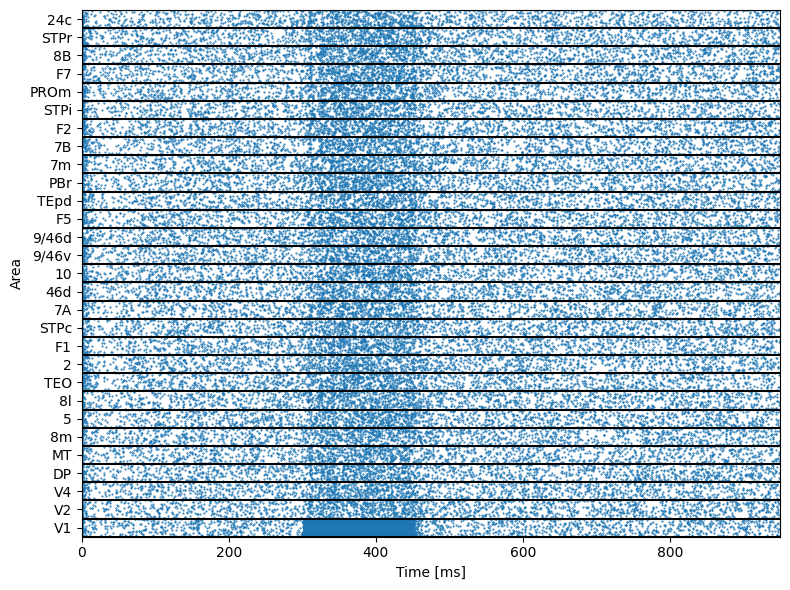

In [27]:
times, indices = np.where(runner.mon['E.spike'])
times = runner.mon.ts[times]
raster_plot(times, indices, length)